In [2]:
import numpy as np
import pandas as pd
from scraper import StockInfo
import json
import matplotlib.pyplot as plt
import math

In [48]:
ticker = "GOOG"
tick = StockInfo(ticker)
df = pd.read_csv('csv/tickers.csv')
f = open('jsons/valJSON.json')
data = json.loads(json.loads(f.read()))
data = data[ticker]
price = tick.get_marketStockPrice()

[*********************100%***********************]  1 of 1 completed


In [49]:
def remap( x, oMin, oMax, nMin, nMax ):
    reverseInput = False
    oldMin = min( oMin, oMax )
    oldMax = max( oMin, oMax )
    if not oldMin == oMin:
        reverseInput = True

    reverseOutput = False   
    newMin = min( nMin, nMax )
    newMax = max( nMin, nMax )
    if not newMin == nMin :
        reverseOutput = True

    portion = (x-oldMin)*(newMax-newMin)/(oldMax-oldMin)
    if reverseInput:
        portion = (oldMax-x)*(newMax-newMin)/(oldMax-oldMin)

    result = portion + newMin
    if reverseOutput:
        result = newMax - portion

    return result

def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [50]:
prob = data["y"] / np.sum(data["y"])
x = np.array(data["x"])
meanx, stdx = weighted_avg_and_std(x, prob)
print(f"Expected stock price - {meanx}")
print(f"Most recent stock price - {price}")
#x = np.array([-1 + 2 * (z - min(x)) / (max(x) - min(x)) for z in x])
x-= meanx  # the -= means can be read as x = x- np.mean(x)
x /= stdx

Expected stock price - 169.34746432031682
Most recent stock price - 133.51


In [51]:
results = []
volatility = 0.5
drift = 0.2
k = 5000
years = 10
months = 12 * years
for i in range(k):
    basic = np.array([price] * months)
    rand = np.random.choice(data["x"], p=prob, size = months)
    for time in range(1, months):
        next = (basic[time - 1] * np.exp((1 + volatility ) * time / (drift * 10000)) + (rand[time] - basic[time - 1])  * volatility)
        basic[time] = next
    
    results.append(basic)
    
results = np.matrix(results).T

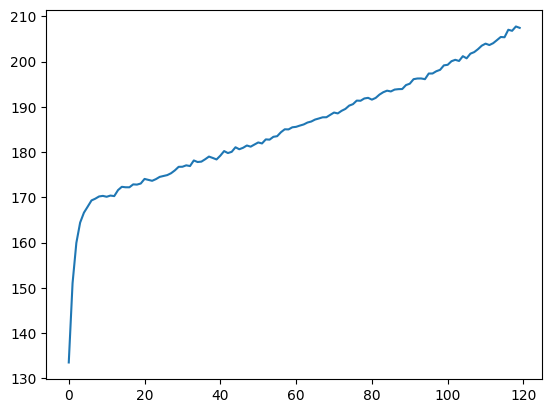

In [52]:
meanGBM = []
for i in range(months):
    meanGBM.append(np.percentile(np.array(results)[i, :], 50))

plt.plot(meanGBM)

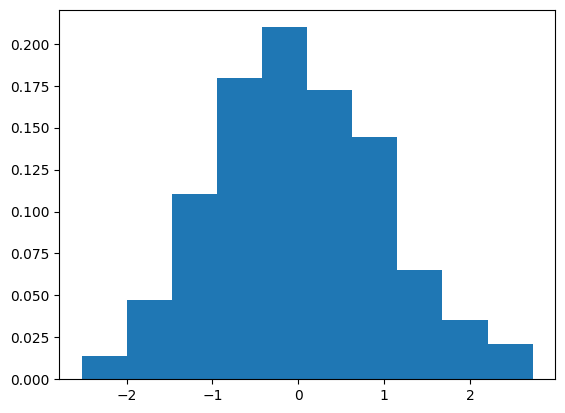

In [53]:
#x = np.array([-1 + 2 * (z - min(x)) / (max(x) - min(x)) for z in x])
plt.hist(x=x, weights=prob)
plt.show()

In [54]:
df = pd.DataFrame(tick.get_historicalPrices())
df['log_ret'] = np.log(df["Adj Close"]) - np.log(df["Adj Close"].shift(1))
mu = df['log_ret'].mean()
sigma = df['log_ret'].std()

[*********************100%***********************]  1 of 1 completed


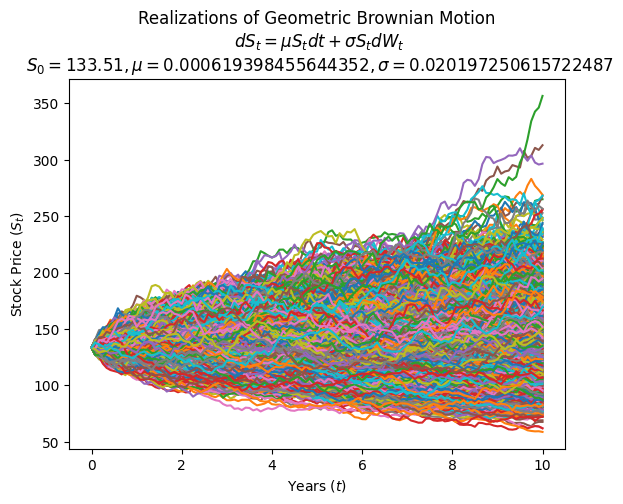

In [55]:
#https://jefjournal.org.za/index.php/jef/article/view/159/573
# time in years
T = 10
# number of steps
n = T * 12
# number of sims
M = 5000
# initial stock price
S0 = price
# calc each time step
dt = T/n
# volatility
sigma = sigma
# drift coefficent
mu = mu
# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.choice(x, p=prob, size=(M, n)).T 
)
# include array of 1's
St = np.vstack([np.ones(M), St])
St = S0 * St.cumprod(axis=0)

time = np.linspace(0,T,n+1)
# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T


plt.plot(tt, St)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

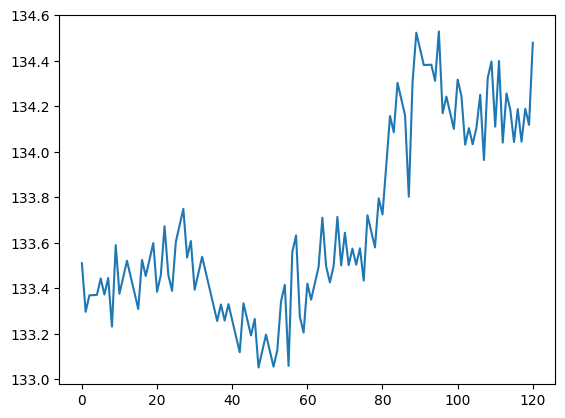

In [56]:
gbm75 = []
gbm25 = []
meanGBM = []
for i in range(len(St)):
    gbm75.append(np.percentile(St[i], 75))
    gbm25.append(np.percentile(St[i], 25))
    meanGBM.append(np.percentile(St[i], 50))
    #meanGBM.append(np.mean(St[i]))

#plt.plot(gbm25)
plt.plot(meanGBM)
#plt.plot(gbm75)